In [1]:
# Importing necessary libraries for time series analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import seaborn as sns

In [3]:
# Read in the data
df = pd.read_csv('/Users/helenamabey/Stats_Spring_2025/Congestion Cleaned.csv')
df.head()

,Date,Month Year,Daily Vehicle Count,Regular Gas Price Average,Midgrade Gas Price Average,Premium Gas Price Average,Monthly_Max_Temp,Monthly_Min_Temp,Monthly_Sum_Precipitation,Monthly_Snowfall
0,2005-01-01,2005-01,19470,1.7660,1.8760,1.9800,32.3,12.7,2.29,36.0
1,2005-02-01,2005-02,21207,1.8550,1.9650,2.0650,33.9,10.5,2.14,37.5
2,2005-03-01,2005-03,22943,2.0825,2.1900,2.2875,39.5,17.5,1.49,20.0
3,2005-04-01,2005-04,21288,2.2300,2.3425,2.4450,49.9,24.0,2.24,20.0
4,2005-05-01,2005-05,23505,2.1540,2.2640,2.3640,62.1,30.5,1.01,2.0


In [5]:
# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [7]:
# Define function to assign seasons
def assign_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

# Create 'Season' column
df['Season'] = df.index.month.map(assign_season)

# Convert 'Season' to dummy variables (one-hot encoding)
df = pd.get_dummies(df, columns=['Season'], drop_first=True)

df.head() # Verify dummy columns are added

,Month Year,Daily Vehicle Count,Regular Gas Price Average,Midgrade Gas Price Average,Premium Gas Price Average,Monthly_Max_Temp,Monthly_Min_Temp,Monthly_Sum_Precipitation,Monthly_Snowfall,Season_Spring,Season_Summer,Season_Winter
Date,,,,,,,,,,,,
2005-01-01,2005-01,19470,1.7660,1.8760,1.9800,32.3,12.7,2.29,36.0,0,0,1
2005-02-01,2005-02,21207,1.8550,1.9650,2.0650,33.9,10.5,2.14,37.5,0,0,1
2005-03-01,2005-03,22943,2.0825,2.1900,2.2875,39.5,17.5,1.49,20.0,1,0,0
2005-04-01,2005-04,21288,2.2300,2.3425,2.4450,49.9,24.0,2.24,20.0,1,0,0
2005-05-01,2005-05,23505,2.1540,2.2640,2.3640,62.1,30.5,1.01,2.0,1,0,0


In [9]:
# Add quadratic transformation for Monthly_Max_Temp
df['Monthly_Max_Temp_Squared'] = df['Monthly_Max_Temp'] ** 2
df.head()

,Month Year,Daily Vehicle Count,Regular Gas Price Average,Midgrade Gas Price Average,Premium Gas Price Average,Monthly_Max_Temp,Monthly_Min_Temp,Monthly_Sum_Precipitation,Monthly_Snowfall,Season_Spring,Season_Summer,Season_Winter,Monthly_Max_Temp_Squared
Date,,,,,,,,,,,,,
2005-01-01,2005-01,19470,1.7660,1.8760,1.9800,32.3,12.7,2.29,36.0,0,0,1,1043.29
2005-02-01,2005-02,21207,1.8550,1.9650,2.0650,33.9,10.5,2.14,37.5,0,0,1,1149.21
2005-03-01,2005-03,22943,2.0825,2.1900,2.2875,39.5,17.5,1.49,20.0,1,0,0,1560.25
2005-04-01,2005-04,21288,2.2300,2.3425,2.4450,49.9,24.0,2.24,20.0,1,0,0,2490.01
2005-05-01,2005-05,23505,2.1540,2.2640,2.3640,62.1,30.5,1.01,2.0,1,0,0,3856.41


In [13]:
# Identify available season columns (Pandas may have dropped one)
season_dummies = [col for col in df.columns if col.startswith("Season_")]

# Check what was created
print("Available season columns:", season_dummies)

Available season columns: ['Season_Spring', 'Season_Summer', 'Season_Winter']


In [15]:
# Drop Winter as baseline (or another if needed)
if "Season_Winter" in season_dummies:
    season_dummies.remove("Season_Winter")

In [17]:
# Select independent variables dynamically
X = df[['Monthly_Max_Temp', 'Monthly_Max_Temp_Squared', 'Regular Gas Price Average'] + season_dummies]

# Add constant for regression
X = sm.add_constant(X)

# Check the final DataFrame
print(X.head())  # Verify correct columns are included

            const  Monthly_Max_Temp  Monthly_Max_Temp_Squared  \
Date                                                            
2005-01-01    1.0              32.3                   1043.29   
2005-02-01    1.0              33.9                   1149.21   
2005-03-01    1.0              39.5                   1560.25   
2005-04-01    1.0              49.9                   2490.01   
2005-05-01    1.0              62.1                   3856.41   

            Regular Gas Price Average  Season_Spring  Season_Summer  
Date                                                                 
2005-01-01                     1.7660              0              0  
2005-02-01                     1.8550              0              0  
2005-03-01                     2.0825              1              0  
2005-04-01                     2.2300              1              0  
2005-05-01                     2.1540              1              0  


In [19]:
# Define dependent variable
y = df['Daily Vehicle Count']

# 70/30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

# Log-transform the target variable
y_train_log = np.log(y_train)

# Fit the model
model_sm_log = sm.OLS(y_train_log, X_train).fit()

# Print model summary
print(model_sm_log.summary())


                             OLS Regression Results                            
Dep. Variable:     Daily Vehicle Count   R-squared:                       0.750
Model:                             OLS   Adj. R-squared:                  0.737
Method:                  Least Squares   F-statistic:                     57.49
Date:                 Sat, 08 Mar 2025   Prob (F-statistic):           2.30e-27
Time:                         08:40:42   Log-Likelihood:                 135.01
No. Observations:                  102   AIC:                            -258.0
Df Residuals:                       96   BIC:                            -242.3
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const       

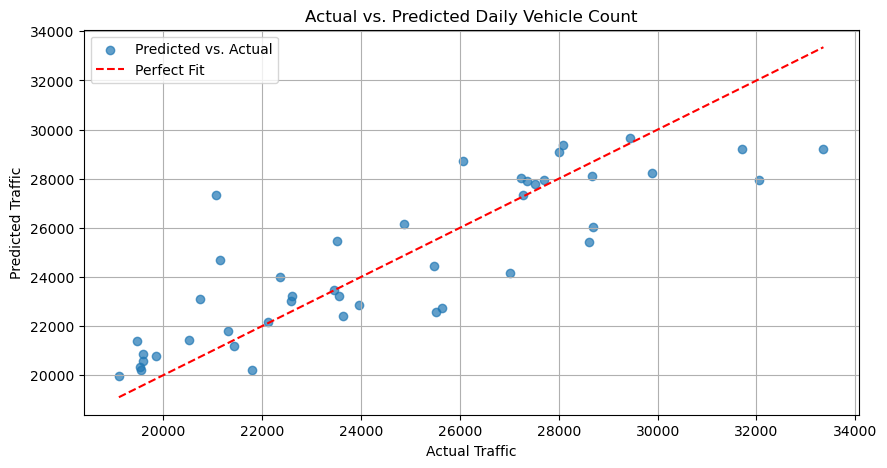

In [21]:
# Predict on test data (log scale)
y_pred_log = model_sm_log.predict(X_test)

# Convert back from log-scale
correction_factor = np.exp(model_sm_log.resid.var() / 2)
y_pred_original_scale = np.exp(y_pred_log) * correction_factor

# Create plot
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred_original_scale, alpha=0.7, label="Predicted vs. Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="dashed", label="Perfect Fit")
plt.xlabel("Actual Traffic")
plt.ylabel("Predicted Traffic")
plt.title("Actual vs. Predicted Daily Vehicle Count")
plt.legend()
plt.grid()
plt.show()

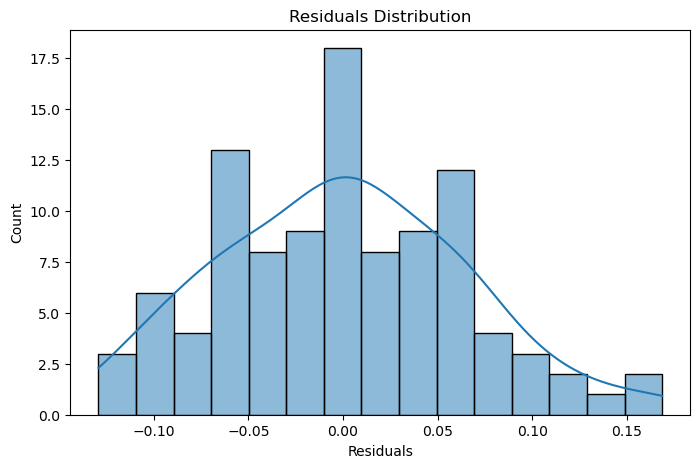

In [29]:
residuals = model_sm_log.resid

# Plot residuals distribution
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=15)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.show()

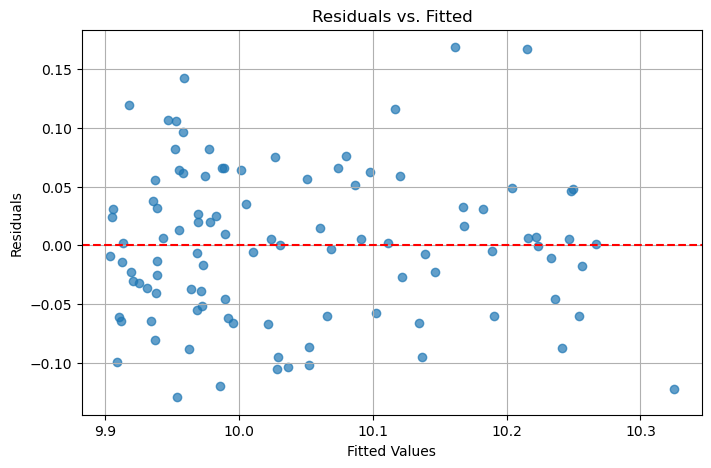

In [31]:
plt.figure(figsize=(8,5))
plt.scatter(model_sm_log.fittedvalues, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='dashed')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.grid()
plt.show()

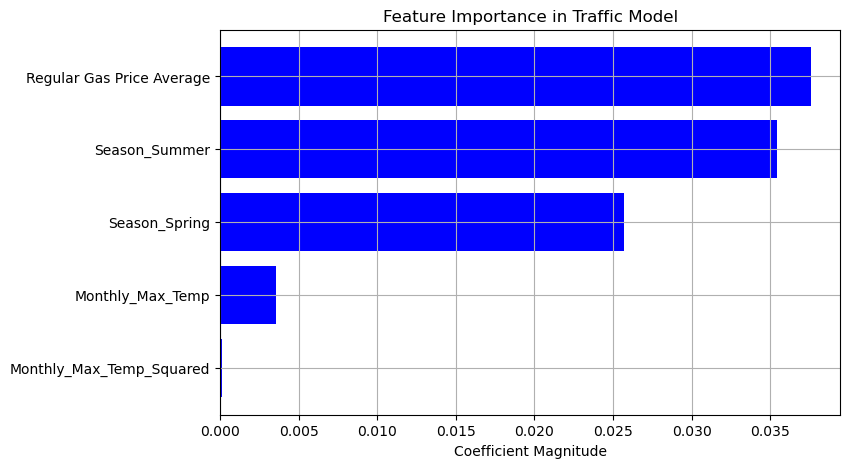

In [33]:
coefs = model_sm_log.params[1:]  # Exclude constant
coefs = coefs.abs().sort_values()  # Sort by magnitude

plt.figure(figsize=(8,5))
plt.barh(coefs.index, coefs.values, color="blue")
plt.xlabel("Coefficient Magnitude")
plt.title("Feature Importance in Traffic Model")
plt.grid()
plt.show()

In [35]:
# Create date range for March - December 2017
future_dates = pd.date_range(start="2017-03-01", end="2017-12-01", freq="MS")

# Estimate Monthly_Max_Temp & Regular Gas Price based on historical monthly averages
monthly_avg_temp = df.groupby(df.index.month)['Monthly_Max_Temp'].mean()
monthly_avg_gas = df.groupby(df.index.month)['Regular Gas Price Average'].mean()

# Assign estimated values for future months
future_temps = [monthly_avg_temp[date.month] for date in future_dates]
future_gas_prices = [monthly_avg_gas[date.month] for date in future_dates]

# Create DataFrame for future data
future_df = pd.DataFrame({
    'Monthly_Max_Temp': future_temps,
    'Regular Gas Price Average': future_gas_prices
}, index=future_dates)

# Add the quadratic term for Monthly_Max_Temp
future_df['Monthly_Max_Temp_Squared'] = future_df['Monthly_Max_Temp'] ** 2

# Assign seasons and create dummy variables
def assign_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

future_df['Season'] = future_df.index.month.map(assign_season)

# One-hot encode seasons (ensure alignment with training data)
future_df = pd.get_dummies(future_df, columns=['Season'], drop_first=False)

# Drop Winter as baseline if it exists
if "Season_Winter" in future_df.columns:
    future_df.drop(columns=["Season_Winter"], inplace=True)

# Ensure same feature columns as the model
future_df = sm.add_constant(future_df)

future_df.head()  # Verify the structure

,const,Monthly_Max_Temp,Regular Gas Price Average,Monthly_Max_Temp_Squared,Season_Fall,Season_Spring,Season_Summer
2017-03-01,1.0,41.833333,2.724792,1750.027778,0,1,0
2017-04-01,1.0,49.208333,2.880000,2421.460069,0,1,0
2017-05-01,1.0,59.350000,3.014167,3522.422500,0,1,0
2017-06-01,1.0,72.100000,3.050000,5198.410000,0,0,1
2017-07-01,1.0,76.766667,3.038458,5893.121111,0,0,1


In [39]:
print("Model Features:", X_train.columns)
print("Future Data Features:", future_df.columns)

Model Features: Index(['const', 'Monthly_Max_Temp', 'Monthly_Max_Temp_Squared',
       'Regular Gas Price Average', 'Season_Spring', 'Season_Summer'],
      dtype='object')
Future Data Features: Index(['const', 'Monthly_Max_Temp', 'Regular Gas Price Average',
       'Monthly_Max_Temp_Squared', 'Season_Fall', 'Season_Spring',
       'Season_Summer'],
      dtype='object')


In [41]:
# Ensure all expected season columns exist in future_df
expected_season_dummies = ['Season_Spring', 'Season_Summer']  # The ones in the model

# Remove extra season columns if they exist
for col in future_df.columns:
    if col.startswith("Season_") and col not in expected_season_dummies:
        future_df.drop(columns=[col], inplace=True)

# Add missing season columns if they are not present
for col in expected_season_dummies:
    if col not in future_df.columns:
        future_df[col] = 0  # Assign 0 for missing season

# Ensure final feature set matches model expectations
future_df = future_df[X_train.columns]

# Print final check
print("Updated Future Data Features:", future_df.columns)

Updated Future Data Features: Index(['const', 'Monthly_Max_Temp', 'Monthly_Max_Temp_Squared',
       'Regular Gas Price Average', 'Season_Spring', 'Season_Summer'],
      dtype='object')


In [43]:
# Ensure all expected season columns exist in future_df
expected_season_dummies = ['Season_Spring', 'Season_Summer']  # The ones in the model

# Remove extra season columns if they exist
for col in future_df.columns:
    if col.startswith("Season_") and col not in expected_season_dummies:
        future_df.drop(columns=[col], inplace=True)

# Add missing season columns if they are not present
for col in expected_season_dummies:
    if col not in future_df.columns:
        future_df[col] = 0  # Assign 0 for missing season

# Ensure final feature set matches model expectations
future_df = future_df[X_train.columns]

# Print final check
print("Updated Future Data Features:", future_df.columns)


Updated Future Data Features: Index(['const', 'Monthly_Max_Temp', 'Monthly_Max_Temp_Squared',
       'Regular Gas Price Average', 'Season_Spring', 'Season_Summer'],
      dtype='object')


In [45]:
# Predict on corrected future data
future_pred_log = model_sm_log.predict(future_df)

# Convert back from log scale
correction_factor = np.exp(model_sm_log.resid.var() / 2)
future_pred_original_scale = np.exp(future_pred_log) * correction_factor

# Store predictions
future_predictions_df = pd.DataFrame({'Predicted_Vehicle_Count': future_pred_original_scale}, index=future_dates)

print(future_predictions_df)  # Check final predictions

            Predicted_Vehicle_Count
2017-03-01             21887.750817
2017-04-01             22612.009212
2017-05-01             24125.269690
2017-06-01             27314.468060
2017-07-01             28732.080849
2017-08-01             27723.929848
2017-09-01             25037.186087
2017-10-01             22768.759211
2017-11-01             21175.313216
2017-12-01             20604.289125


In [47]:
# Extract actual 2016 traffic (Jan-Dec)
traffic_2016 = df.loc["2016", "Daily Vehicle Count"]

# Extract actual 2017 traffic (Jan-Feb)
traffic_2017_actual = df.loc["2017-01":"2017-02", "Daily Vehicle Count"]

# Create full 2017 index (Jan-Dec)
full_2017_index = pd.date_range(start="2017-01-01", periods=12, freq="MS")

# Create a DataFrame with full 2017 index
comparison_df = pd.DataFrame(index=full_2017_index)

# Assign 2016 actual traffic (aligned with Jan-Dec)
comparison_df['2016 Traffic'] = traffic_2016.values[:12]

# Assign 2017 actual traffic (only Jan-Feb)
comparison_df.loc["2017-01-01":"2017-02-01", '2017 Actual'] = traffic_2017_actual.values

# Assign 2017 predicted traffic (only Mar-Dec)
comparison_df.loc["2017-03-01":"2017-12-01", '2017 Predicted'] = future_predictions_df['Predicted_Vehicle_Count'].values

# Print final comparison table
comparison_df

,2016 Traffic,2017 Actual,2017 Predicted
2017-01-01,22470,21883.0,NaN
2017-02-01,20829,23391.0,NaN
2017-03-01,25512,NaN,21887.750817
2017-04-01,23563,NaN,22612.009212
2017-05-01,27800,NaN,24125.269690
2017-06-01,31702,NaN,27314.468060
2017-07-01,33354,NaN,28732.080849
2017-08-01,32044,NaN,27723.929848
2017-09-01,30647,NaN,25037.186087
2017-10-01,27020,NaN,22768.759211


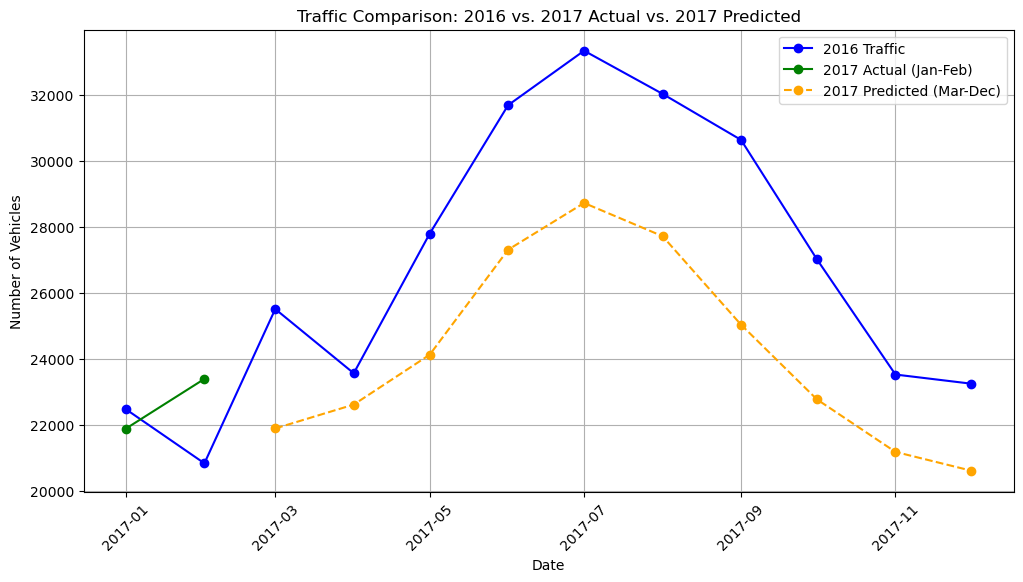

In [49]:
plt.figure(figsize=(12, 6))

# Plot actual 2016 traffic
plt.plot(comparison_df.index, comparison_df['2016 Traffic'], label="2016 Traffic", marker="o", linestyle="-", color="blue")

# Plot actual 2017 traffic (Jan-Feb)
plt.plot(comparison_df.index[:2], comparison_df['2017 Actual'].dropna(), label="2017 Actual (Jan-Feb)", marker="o", linestyle="-", color="green")

# Plot predicted 2017 traffic (Mar-Dec)
plt.plot(comparison_df.index[2:], comparison_df['2017 Predicted'].dropna(), label="2017 Predicted (Mar-Dec)", marker="o", linestyle="dashed", color="orange")

plt.xlabel("Date")
plt.ylabel("Number of Vehicles")
plt.title("Traffic Comparison: 2016 vs. 2017 Actual vs. 2017 Predicted")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()